In [1]:
#from Model_12 import Autoencoder # if you want you can import model from a source code or i also embedded the model in this jupyter notebook
from utils_V2 import Reconstructed_writer # bu kisim tahmin edilen akis alaninin disarida bir dosyaya yazilmasi icin. 
                                           #burada ekstra source codelar ve duzenlemeler var/ o yuzden bunun yerine direkt plot function gorsel olusturuyor.

import numpy as np
from sklearn.model_selection import train_test_split
#from torch.u3tils.data import random_split
import torch
import torch.nn as nn
from torchviz import make_dot
from torchsummary import summary
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# a seed value is assigned to control randomization
my_seed = 24
def set_seed (my_seed = 24):
  np.random.seed(my_seed)
  torch.manual_seed(my_seed)
  torch.cuda.manual_seed(my_seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(my_seed=my_seed)

# Load Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

data = np.load("flowfield.npy")
minibatch = 5 # # how many samples per batch to load
print(data.shape)
if minibatch == None:
  minibatch = data.shape[0]

# uploading the data from numpy file

flow_cond = np.load("flowcon.npy")
x_coordinates = np.load("x_coordinate.npy")
y_coordinates = np.load("y_coordinate.npy")

print(data.shape)
#data = data.to(device)
print(x_coordinates.shape)
#to split randomly

cuda
(50, 3, 150, 498)
(50, 3, 150, 498)
(50, 150, 498)


# Normalize the data

In [3]:
# normalizing the flow field
flowfield_mean = np.mean(data, axis=0) # cell-based mean values
flowfield_std = np.std(data, axis=0) # cell-based std values
print(flowfield_mean.shape)

normalized_data = (data - flowfield_mean) / flowfield_std

(3, 150, 498)


# Split and Data Loader

In [4]:
# splitting train and validation data (coordinates, AoA whole together shuffled)
train_data, val_data, train_xcoord, test_xcoord, train_ycoord, test_ycoord, train_flowcon, val_flowcon = train_test_split(normalized_data, x_coordinates, y_coordinates, flow_cond, test_size=0.2)
print(train_data[1].shape)

# make numpy to tensor
torch.set_default_dtype(torch.float64)

train_loader = DataLoader(torch.tensor(train_data), batch_size=minibatch, shuffle=False)
val_loader = DataLoader(torch.tensor(val_data), batch_size=val_data.shape[0], shuffle=False)

(3, 150, 498)


# Visualize the original data (1 sample)

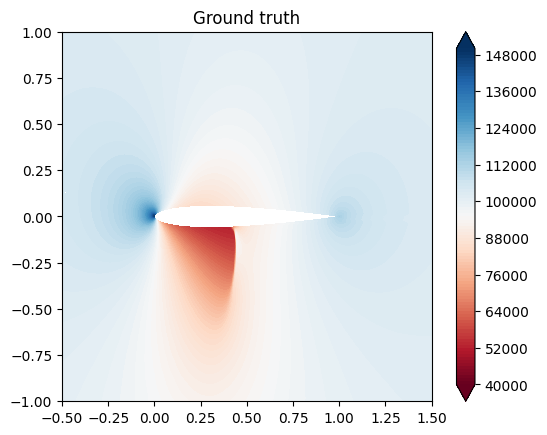

In [5]:
original = train_data * flowfield_std + flowfield_mean  # from training set, reconstruct to original data to create plot
original.shape

x = train_xcoord[1]  # x coordinates of the grid
y = train_ycoord[1]  # y coordinates of the grid
z = original[1,0]    # original flow field

plt.title("Ground truth")
plt.contourf(x,y,z, levels= np.linspace(40000.,150000.,111), cmap = 'RdBu', extend = 'both')
# plt.contourf(x,y,z, levels= 10, cmap = 'RdBu')
plt.colorbar(orientation="vertical")
plt.xlim(-.5,1.5)
plt.ylim(-1.0,1.0)
plt.gca().set_aspect('equal', adjustable='box')

# Plot Function

In [11]:
#@title Plot
def contour_plot(x,y,original, recons = None, mean=flowfield_mean, std=flowfield_std, coef = "p"):
  if coef == "p":
    coef_idx = 0
  elif coef == "u":
    coef_idx = 1
  elif coef == "v":
    coef_idx = 2
  original = original[coef_idx] * std[coef_idx] + mean[coef_idx]  # standardize
  # original = original[coef_idx] * (std-mean)[coef_idx] + mean[coef_idx]  # normalize
  
  if recons.any() == None:
    x = np.concatenate((x, x[0].reshape(1,-1)),axis=0)
    y = np.concatenate((y, y[0].reshape(1,-1)),axis=0)
    z = np.concatenate((original, original[0].reshape(1,-1)),axis=0)
    plt.contourf(x,y,z, levels= 10, cmap = 'RdBu',vmin=-2,vmax=2)
    plt.colorbar()
    plt.xlim(-.5,1.5)
    plt.ylim(-1.0, 1.0)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
  else:

    recons = recons[coef_idx] * std[coef_idx] + mean[coef_idx] # standardize 풀고
    # recons = recons[coef_idx] * (std-mean)[coef_idx] + mean[coef_idx] # normalize 풀고
    # recons = recons[coef_idx]
    #x = np.concatenate((x, x[0].reshape(1,-1)),axis=0)
    #y = np.concatenate((y, y[0].reshape(1,-1)),axis=0)
      
    plt.figure(figsize=(18,8),dpi=150)
    for i in range(3):
      plt.subplot(1,3,i+1)
      if i ==0:
        #z = np.concatenate((original, original[0].reshape(1,-1)),axis=0)
        z = original
        plt.title("Ground truth")
        plt.contourf(x,y,z, levels= np.linspace(40000.,150000.,111), cmap = 'RdBu', extend = 'both')
        # plt.contourf(x,y,z, levels= 10, cmap = 'RdBu')
        plt.colorbar(orientation="vertical")
        plt.xlim(-.5,1.5)
        plt.ylim(-1.0, 1.0)
        plt.gca().set_aspect('equal', adjustable='box')
          
      elif i ==1:
        z = recons
        #z = np.concatenate((recons, recons[0].reshape(1,-1)),axis=0)
        plt.title("Reconstructed")
        plt.contourf(x,y,z, levels= np.linspace(40000.,150000.,111), cmap = 'RdBu', extend = 'both')
        # plt.contourf(x,y,z, levels= np.linspace(-0,1,11), cmap = 'RdBu')
        # plt.contourf(x,y,z, levels= 10, cmap = 'RdBu')
        plt.colorbar(orientation="vertical")
        plt.xlim(-.5,1.5)
        plt.ylim(-1.0, 1.0)
        plt.gca().set_aspect('equal', adjustable='box')
        
      else:
        #z = recons-original
        z = abs(recons-original) / original
        #z = np.concatenate((recons-original, (recons[0]-original[0]).reshape(1,-1)),axis=0)
        plt.title("Error")
        # plt.contourf(x,y,z, levels= np.linspace(-.05,.05,11), cmap = 'RdBu', extend = 'both')
        plt.contourf(x,y,np.abs(z), levels= np.linspace(-.0,.1,111), cmap = 'Reds', extend = 'max')
        plt.colorbar(orientation="vertical")
        
        plt.xlim(-.5,1.5)
        plt.ylim(-1.0, 1.0)
        plt.gca().set_aspect('equal', adjustable='box')
      
    plt.show()

# MODEL

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder kısmı
        self.encoder = nn.Sequential(
            #input channel arrange
            self.conv_block(3, 16, 1, padding=0),
            
            #1
            nn.MaxPool2d(2, padding=(1, 1)),
            self.conv_block(16, 32, 3),
            
            #2
            nn.MaxPool2d(2, padding=(0, 1)),
            self.conv_block(32, 64, 3),
            
            #3
            nn.MaxPool2d(2, padding=(1, 1)),
            self.conv_block(64, 128, 3),
            
            #4
            nn.MaxPool2d(2, padding=(0, 0)),
            self.conv_block(128, 128, 3),
            
            #5
            nn.MaxPool2d(2, padding=(1, 0)),
            self.conv_block(128, 128, 3),
            
            #6
            nn.MaxPool2d(2, padding=(1, 0)),
            self.conv_block(128, 128, 3),
            
            #7
            nn.MaxPool2d(2, padding=(0, 0)),
            self.conv_block(128, 128, 3),
            
            #Flatten and FCN
            nn.Flatten(),
            nn.Linear(128 * 2 * 4, 32)
        
        )

        # Decoder kısmı
        self.decoder = nn.Sequential(
            nn.Linear(32, 128 * 2 * 4),
            nn.Unflatten(1, (128, 2, 4)),
            
            #1
            nn.Upsample(size=(4,8), mode='bicubic'),
            self.convTranspose_block(128, 128, 3),
                        
            #2
            nn.Upsample(size=(6,16), mode='bicubic'),
            self.convTranspose_block(128, 128, 3),
                                    
            #3
            nn.Upsample(size=(10,32), mode='bicubic'),
            self.convTranspose_block(128, 128, 3),
                        
            #4
            nn.Upsample(size=(20,64), mode='bicubic'),
            self.convTranspose_block(128, 128, 3),
                 
            #5
            nn.Upsample(size=(38,126), mode='bicubic'),
            self.convTranspose_block(128, 64, 3),
                        
            #6
            nn.Upsample(size=(76,250), mode='bicubic'),
            self.convTranspose_block(64, 32, 3),
                                   
            #7
            nn.Upsample(size=(150,498), mode='bicubic'),
            self.convTranspose_block(32, 16, 3),
                                   
            #output
            nn.Conv2d(16, 3, 1, stride=1)
        )

    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed

    def encode(self, x):
        output = self.encoder(x)
        return output

    def decode(self, x):
        output = self.decoder(x)
        return output

    def conv_block(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def convTranspose_block(self, in_channels, out_channels, kernel_size, stride=1, padding=1, Out_P=0):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, Out_P),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    # initilaize the parameters
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)

################################ Testing Model ######################################
# Autoencoder'i oluştur
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#autoencoder = Autoencoder().to(device=device)
#print(autoencoder)

#summary(autoencoder, (3, 150, 498), device='cuda')
# Giriş verisi
#input_data = torch.randn(3, 3, 150, 498).to(device)

# Autoencoder üzerinden geçiş
#output = autoencoder(input_data)

# Verify model output
#print("Output shape:", output.shape)



# to make a graph of model architecture
# Model grafiğini oluştur
#dot = make_dot(output, params=dict(autoencoder.named_parameters()))
#dot.render("CNN model", format="png")
# Display the graph directly
#dot.view()

# Training preparations

In [8]:
# Root mean square error
# Root mean square error
criterion = nn.MSELoss()
def RMSELoss(recon_x,x):
    return torch.sqrt(criterion(recon_x,x))

# number of epochs
n_epochs = 300

#lr_step_size = 150
#lr_gamma = 0.2
print(torch.cuda.get_device_name(0))
model = Autoencoder().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f'Toplam parametre sayısı: {total_params}') # to see total parameters

optimizer = optim.Adam(model.parameters(), lr=1e-3)
#scheduler = lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)
start = time.time()
min_val_loss = np.Inf

NVIDIA GeForce GTX 1050 Ti
Toplam parametre sayısı: 1444003


# Training

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

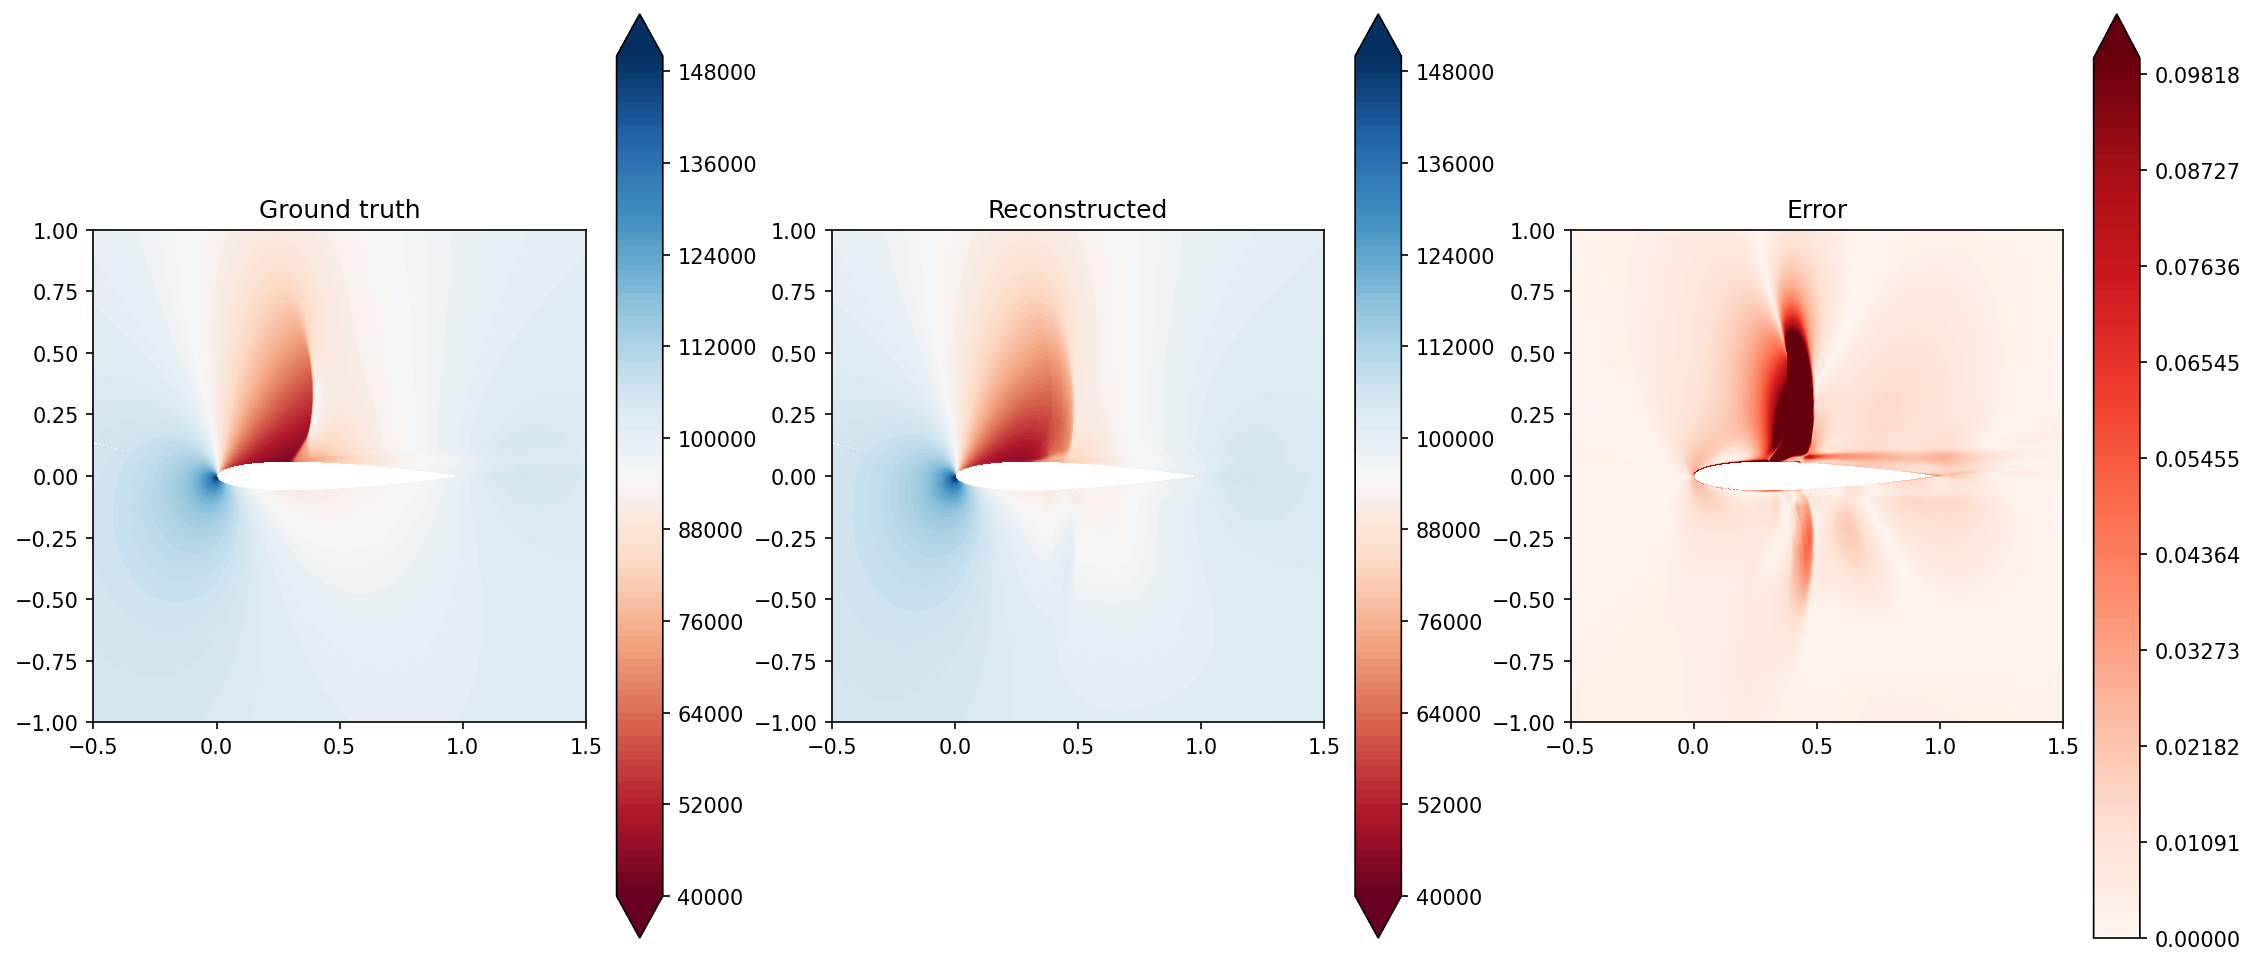

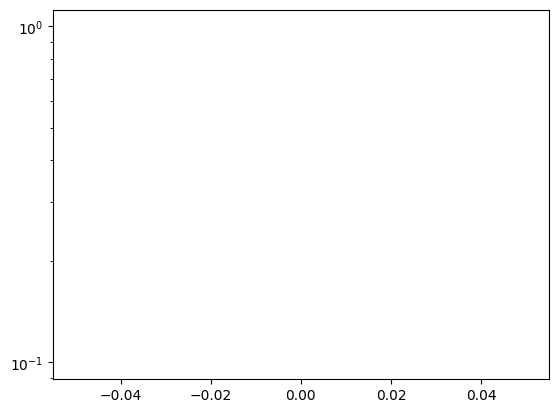

  0%|▎                                                                               | 1/300 [00:18<1:31:29, 18.36s/it]

Epoch[1/300] Time: 1010 Loss: 0.478213


  3%|██▋                                                                            | 10/300 [02:54<1:23:27, 17.27s/it]

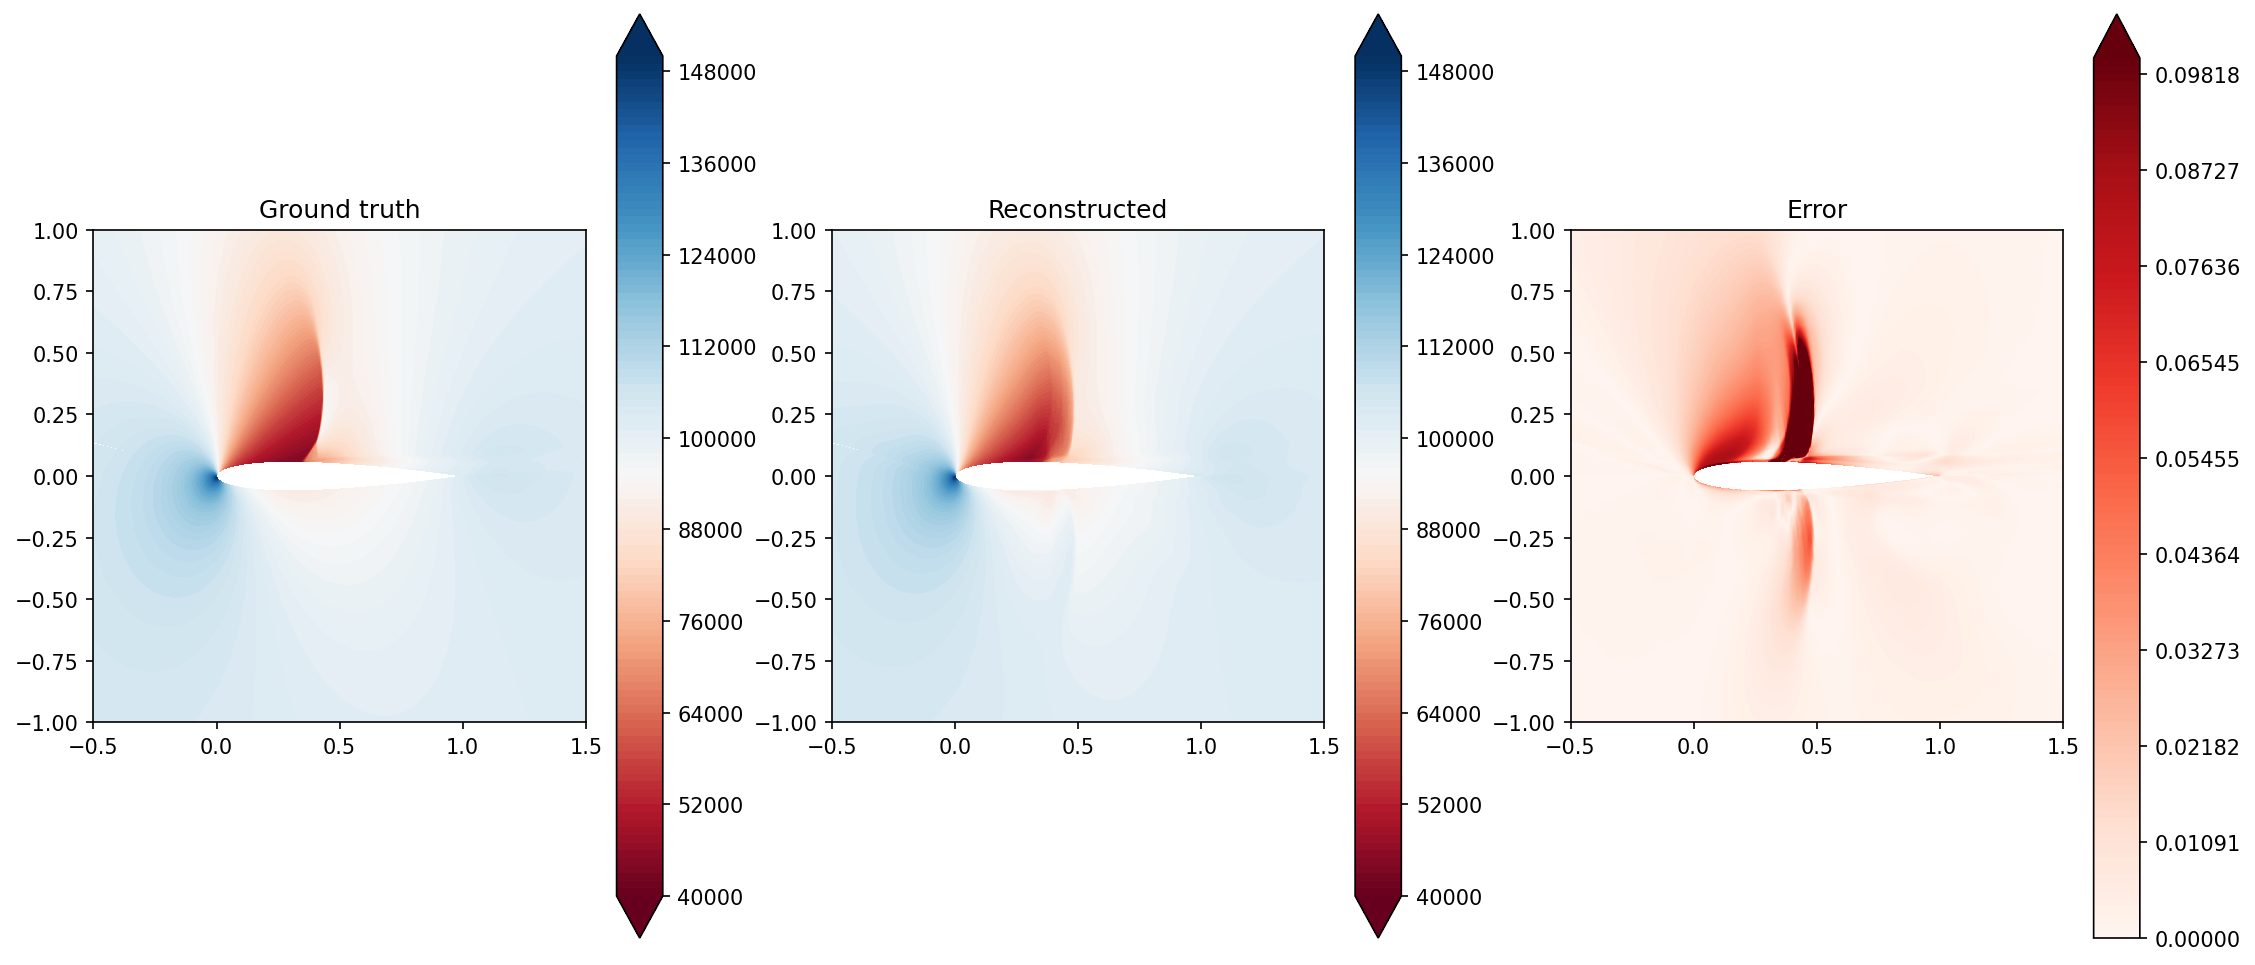

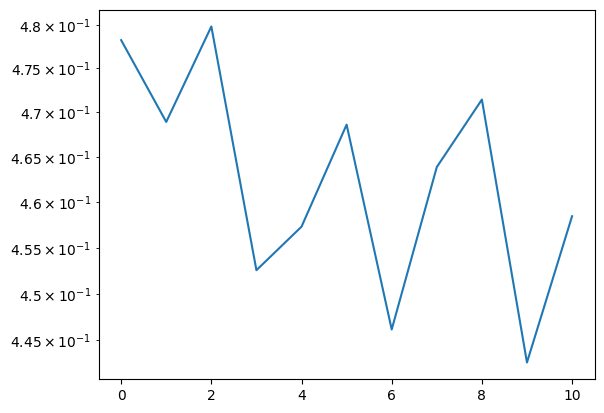

  4%|██▉                                                                            | 11/300 [03:12<1:24:37, 17.57s/it]

Epoch[11/300] Time: 1184 Loss: 0.458432


  7%|█████▎                                                                         | 20/300 [05:48<1:20:42, 17.30s/it]

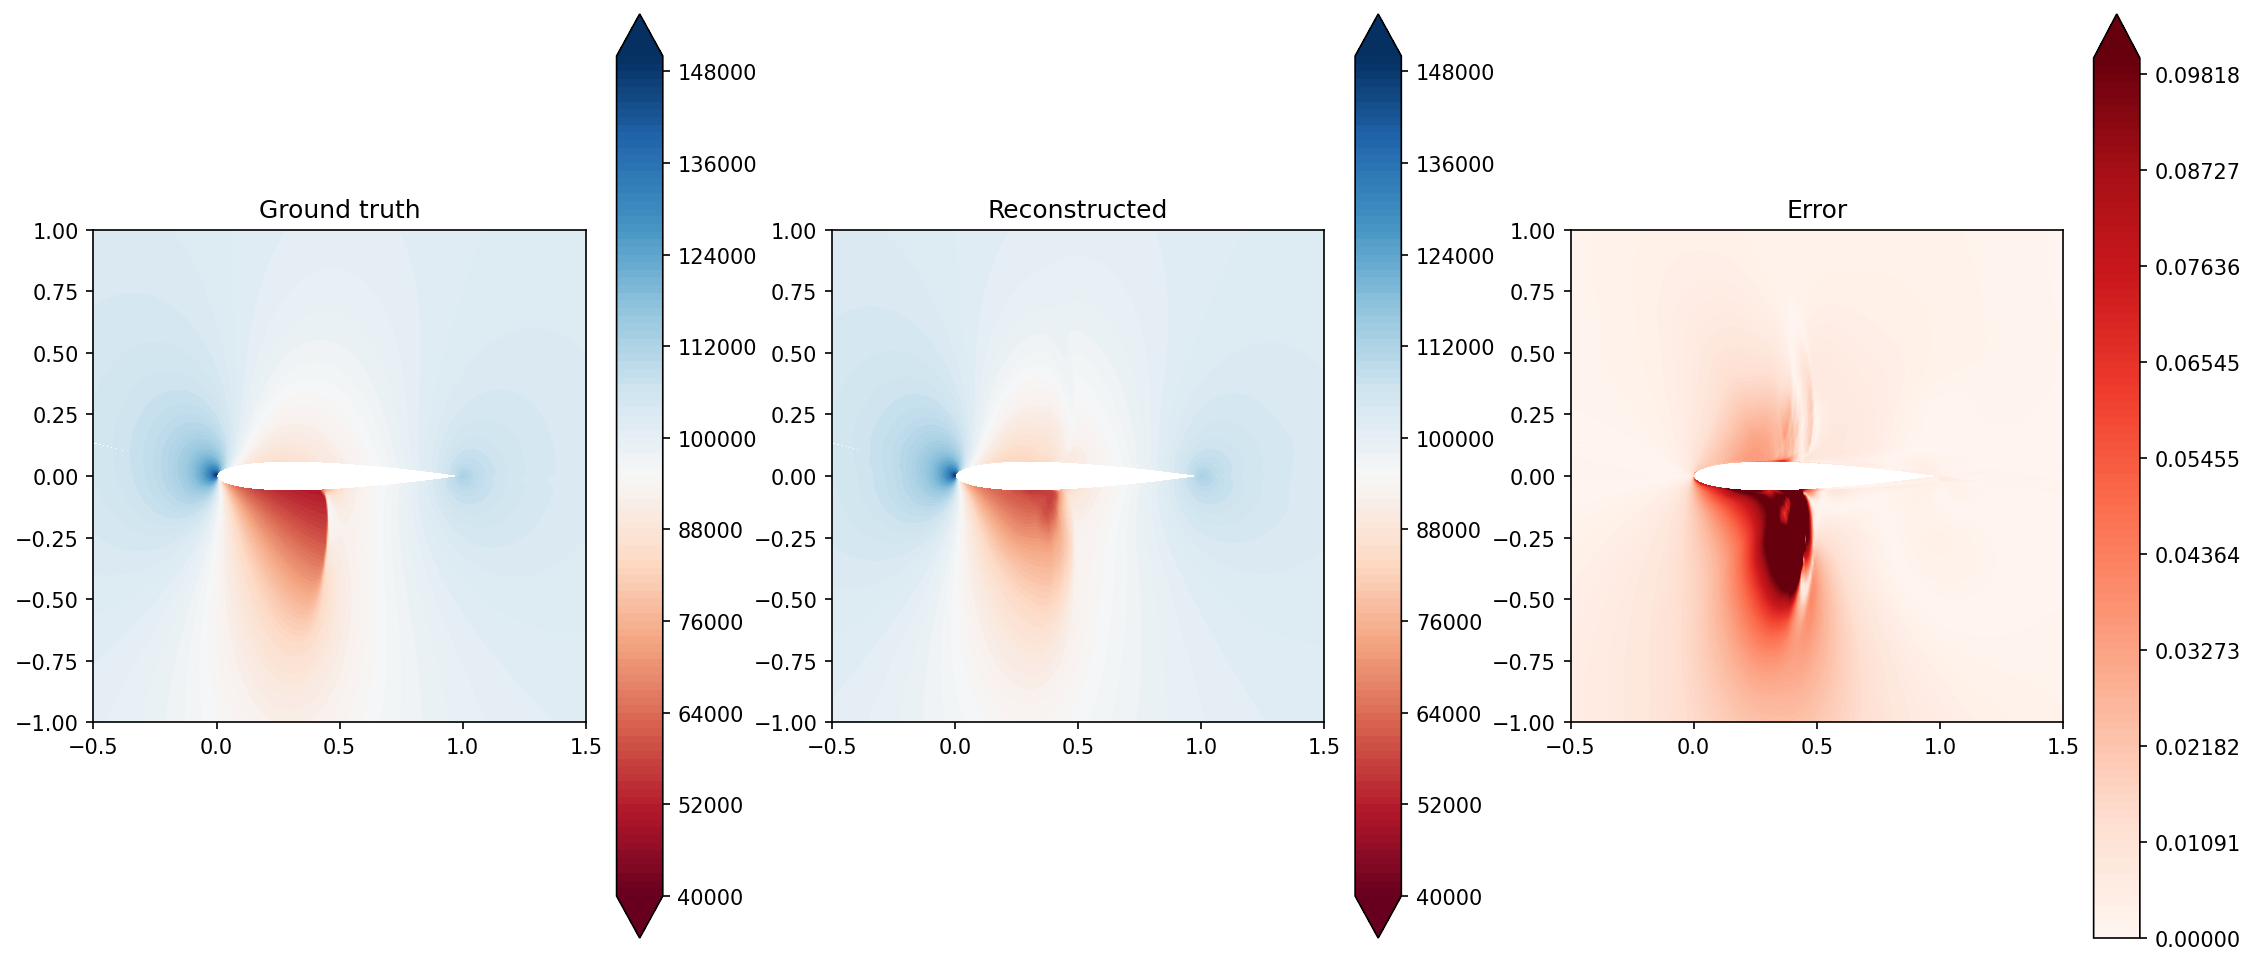

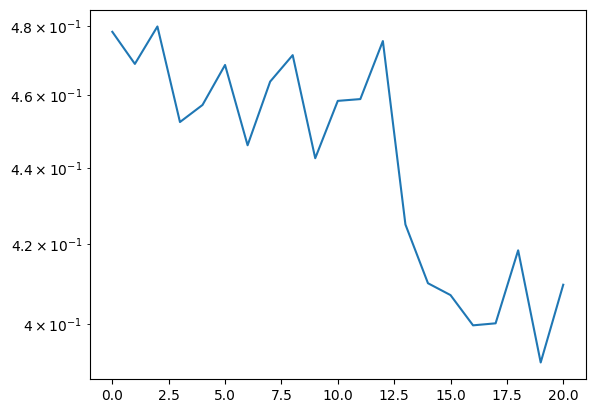

  7%|█████▌                                                                         | 21/300 [06:07<1:21:43, 17.57s/it]

Epoch[21/300] Time: 1358 Loss: 0.409659


 10%|███████▉                                                                       | 30/300 [08:43<1:18:25, 17.43s/it]

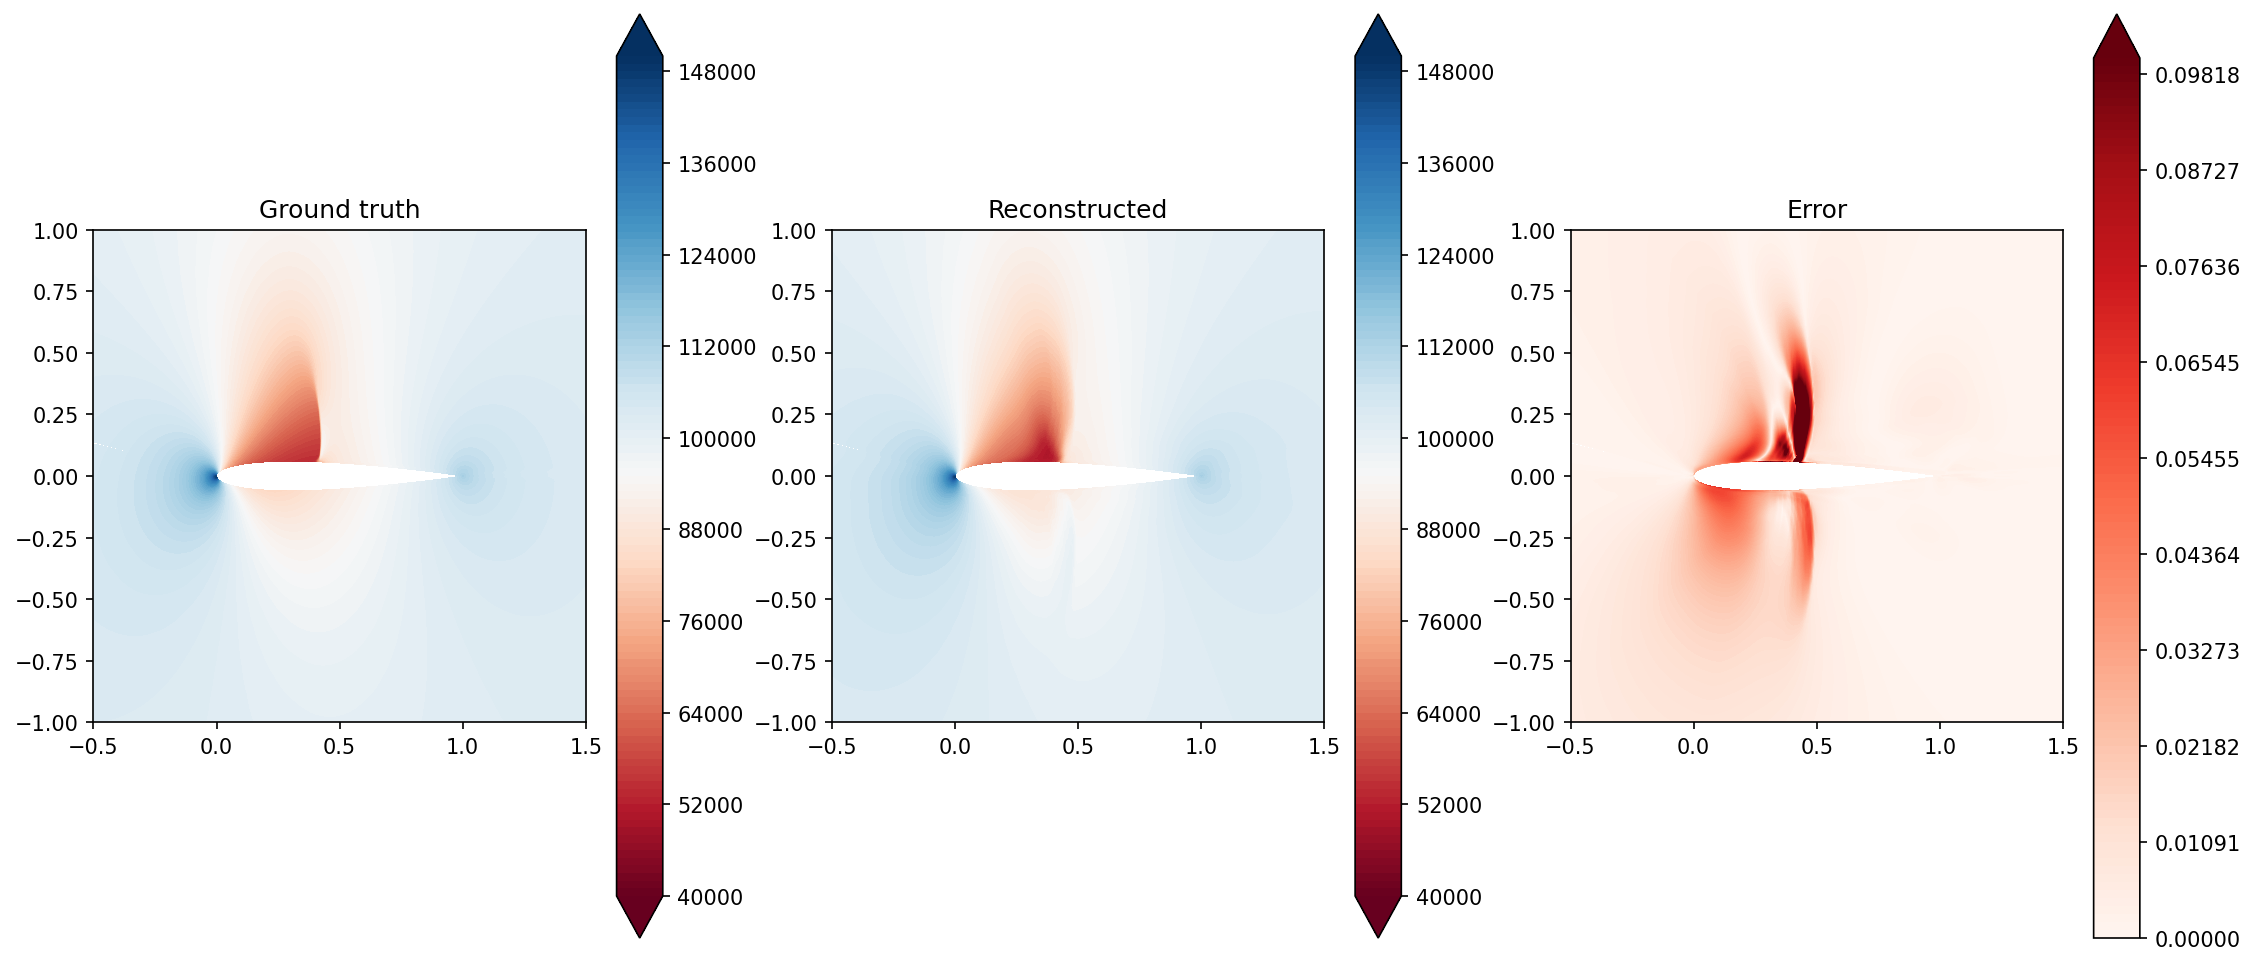

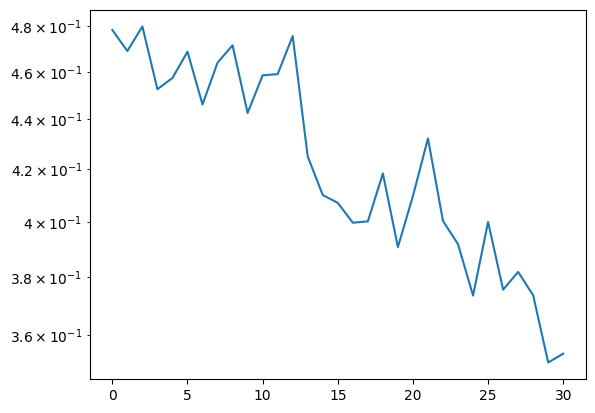

 10%|████████▏                                                                      | 31/300 [09:01<1:19:03, 17.64s/it]

Epoch[31/300] Time: 1533 Loss: 0.353694


 13%|██████████▌                                                                    | 40/300 [11:38<1:15:40, 17.46s/it]

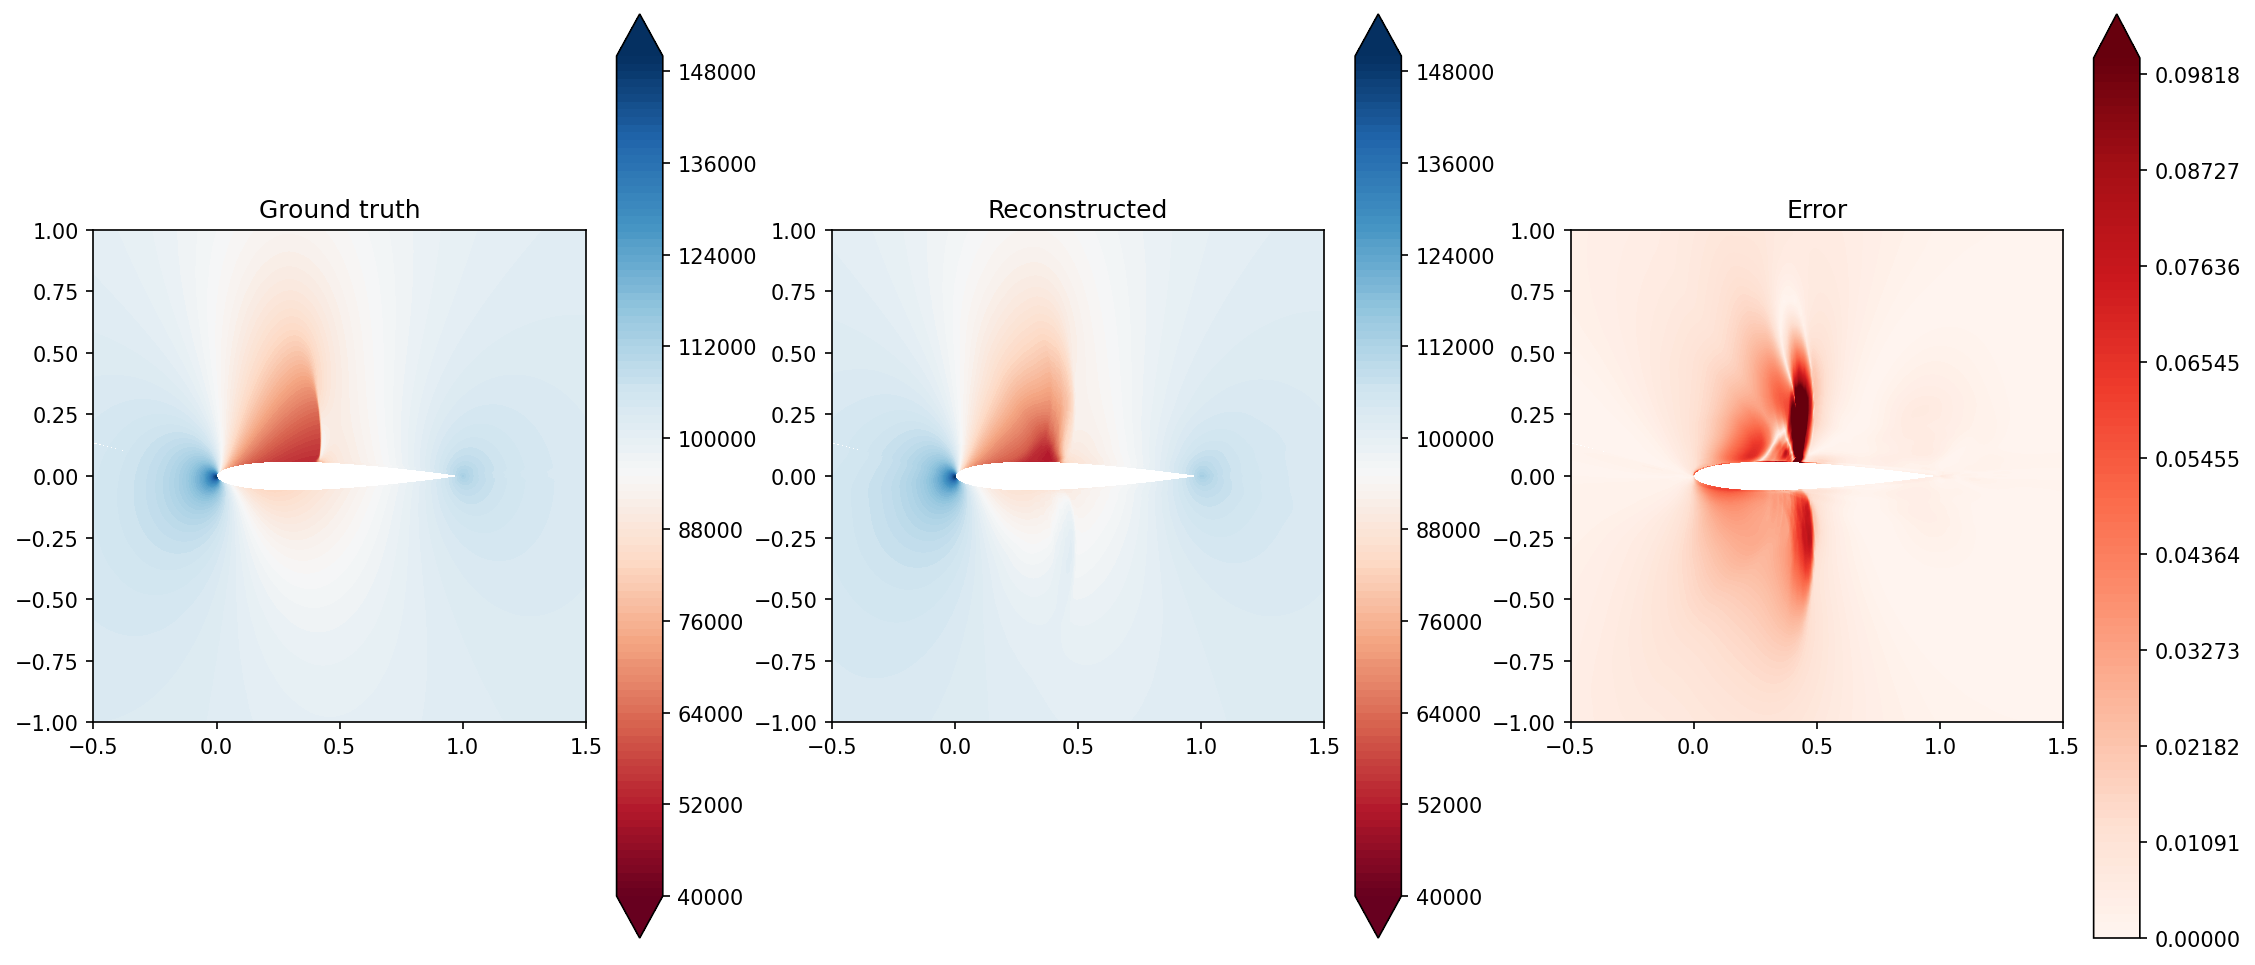

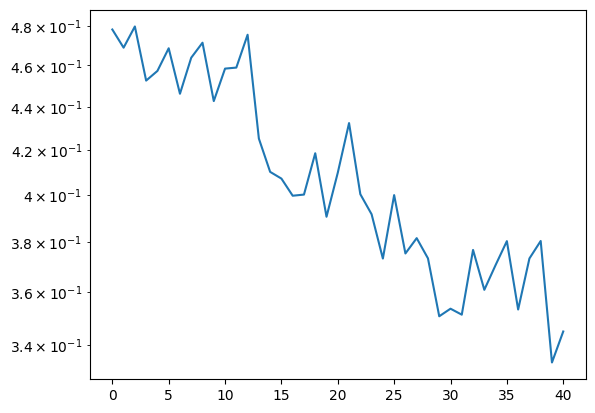

 14%|██████████▊                                                                    | 41/300 [11:56<1:16:54, 17.82s/it]

Epoch[41/300] Time: 1708 Loss: 0.345090


 17%|█████████████▏                                                                 | 50/300 [14:34<1:13:10, 17.56s/it]

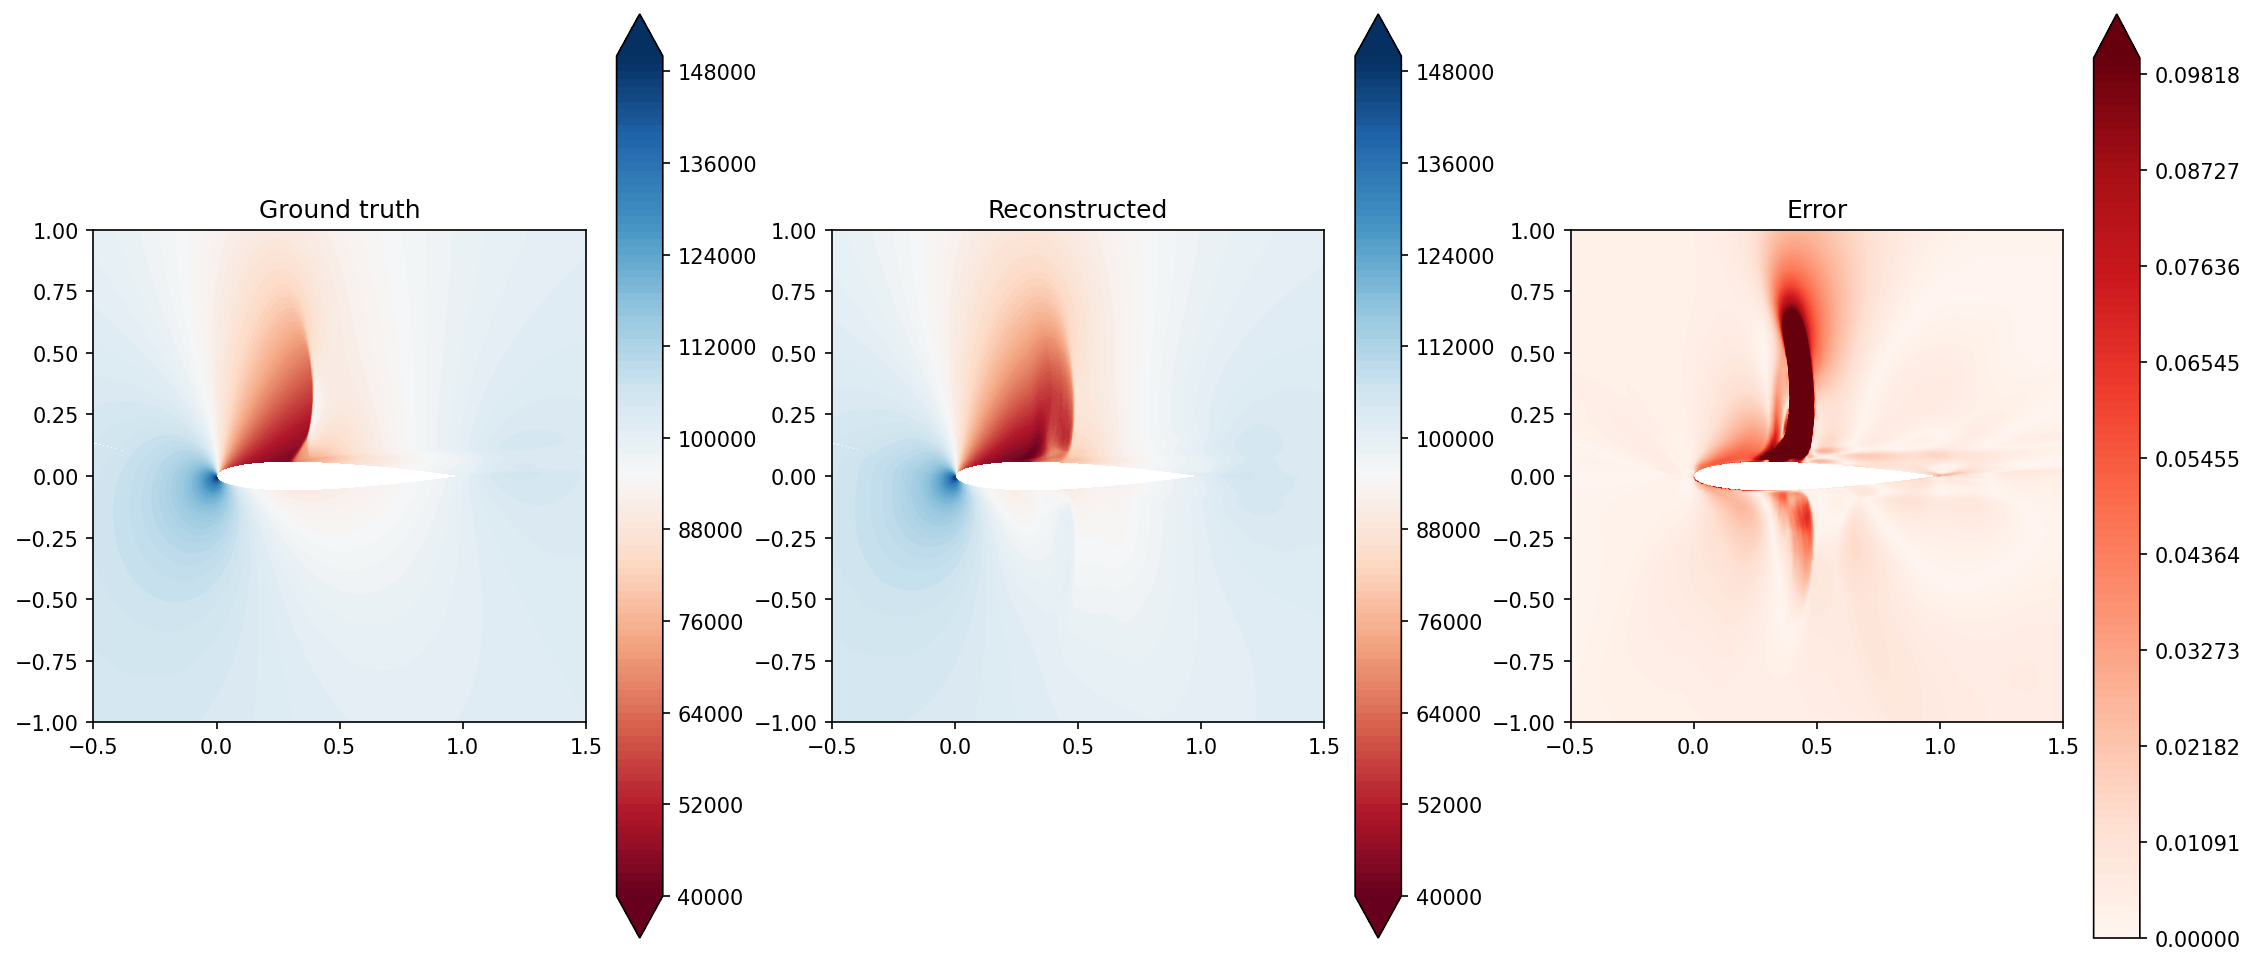

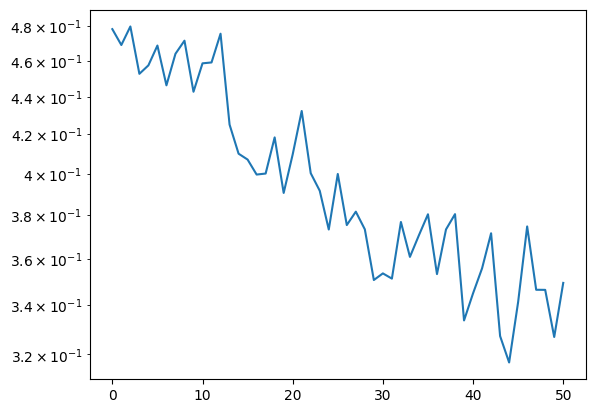

 17%|█████████████▍                                                                 | 51/300 [14:53<1:14:18, 17.90s/it]

Epoch[51/300] Time: 1885 Loss: 0.349567


 19%|███████████████▎                                                               | 58/300 [17:08<1:11:33, 17.74s/it]


KeyboardInterrupt: 

In [13]:
#val_losses = []
loss_his = []

for epoch in tqdm(range(n_epochs)):
    #monitor training loss and validation loss
    train_loss = 0.0
    
    # Empty the outputs list at the beginning of each epoch
    outputs = []
    ###################
    # train the model #
    ###################
    for idx, (images) in enumerate(train_loader):
        images = images.to(device)
        recon_images = model(images)
        loss = RMSELoss(recon_images, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        outputs.append(recon_images)
    loss_his.append(loss.item())
    #scheduler.step()
          
    

    if epoch % 10 == 0:# and epoch != 0:
      
      rand_idx = np.random.randint(low=0, high=minibatch)
      contour_plot(train_xcoord[rand_idx], train_ycoord[rand_idx], images.cpu().numpy()[rand_idx], recon_images.cpu().detach().numpy()[rand_idx]) 

      plt.plot(np.arange(epoch+1),np.array(loss_his)[:])
      plt.yscale('log')
      plt.show()

      to_print = "Epoch[{}/{}] Time: {:.0f} Loss: {:.6f}".format(epoch+1, 
                              n_epochs, time.time()-start, loss.item())
      print(to_print)   

# concatenate outputs list to get the final output tensor
final_output = torch.cat(outputs, dim=0)
print(final_output[1,0,:,:].shape)

# Inference Validation Data

In [ ]:
with torch.no_grad():
    model.eval()
    for images in val_loader:
      images = images.to(device)
      recon_images_val = model(images)
      loss_val_p = RMSELoss(images[:,0], recon_images_val[:,0])
      loss_val_u = RMSELoss(images[:,1], recon_images_val[:,1])
      loss_val_v = RMSELoss(images[:,2], recon_images_val[:,2])
      print(loss_val_p)
      print(loss_val_u)
      print(loss_val_v)

# concatenate outputs list to get the final output tensor
final_output_val = torch.cat((recon_images_val,), dim=0) 

# Reconstruction the Data

In [ ]:
# changing normalized data back to orginal distribution for training dataset
reconstructed_data = torch.zeros(len(train_data),3,150,498)
for i in range(3):
    for k in range(len(train_data)):
        reconstructed_data[k,i,:,:] = final_output[k,i,:,:]* torch.tensor(flowfield_std).to(device)[i] + torch.tensor(flowfield_mean).to(device)[i]
        
# Origininal data
original_data = torch.zeros(len(train_data),3,150,498)
for i in range(3):
    for k in range(len(train_data)):
        original_data[k,i,:,:] = torch.tensor(train_data[k,i,:,:]).to(device)* torch.tensor(flowfield_std).to(device)[i] + torch.tensor(flowfield_mean).to(device)[i]
    
# error data
error_data = original_data - reconstructed_data

# changing normalized data back to orginal distribution for validation dataset
reconstructed_val = torch.zeros(len(val_data),3,150,498)
for i in range(3):
    for k in range(len(val_data)):
        reconstructed_val[k,i,:,:] = final_output_val[k,i,:,:]* torch.tensor(flowfield_std).to(device)[i] + torch.tensor(flowfield_mean).to(device)[i]

# Exporting the Reconstructed Flow Field

In [ ]:
# location of write files
phat_file = r"C:\Users\Abdullah\Desktop\ASDL\Optimization_Team\Toy_Problem\Model\output\v4\P"
uhat_file = r"C:\Users\Abdullah\Desktop\ASDL\Optimization_Team\Toy_Problem\Model\output\v4\u"
vhat_file = r"C:\Users\Abdullah\Desktop\ASDL\Optimization_Team\Toy_Problem\Model\output\v4\v"

#error file locations
pe_file = r"C:\Users\Abdullah\Desktop\ASDL\Optimization_Team\Toy_Problem\Model\output\v4\error\P_error"
ue_file = r"C:\Users\Abdullah\Desktop\ASDL\Optimization_Team\Toy_Problem\Model\output\v4\error\u_error"
ve_file = r"C:\Users\Abdullah\Desktop\ASDL\Optimization_Team\Toy_Problem\Model\output\v4\error\v_error"

# writing constructed data to .dat files / train data
train_write = Reconstructed_writer(dataset=reconstructed_data, flow_cond = flow_cond, flowcon = train_flowcon, phat_file=phat_file, uhat_file=uhat_file, vhat_file=vhat_file, num_cases=len(reconstructed_data), num_rows=150, num_cols=498, num_channels=3) # num_channels-1 due to AoA as channel
export_train = train_write.write_dataset()

# writing error to .dat files / error data
error_write = Reconstructed_writer(dataset=error_data, flow_cond = flow_cond, flowcon = train_flowcon, phat_file=pe_file, uhat_file=ue_file, vhat_file=ve_file, num_cases=len(reconstructed_data), num_rows=150, num_cols=498, num_channels=3) # num_channels-1 due to AoA as channel
export_error = error_write.write_dataset()

# writing constructed data to .dat files / validation data
val_write = Reconstructed_writer(dataset=reconstructed_val, flow_cond = flow_cond, flowcon = val_flowcon, phat_file=phat_file, uhat_file=uhat_file, vhat_file=vhat_file, num_cases=len(reconstructed_val), num_rows=150, num_cols=498, num_channels=3) # num_channels-1 due to AoA as channel
export_val = val_write.write_dataset()

# Save the model
#torch.save(model.state_dict(), r'C:\Users\Abdullah\Desktop\ASDL\Optimization_Team\Toy Problem\Model\conv_autoencoder.pth')

# Load the state of the model from the conv_autoencoder file
# model.load_state_dict(torch.load(r'C:\Users\Abdullah\Desktop\ASDL\Optimization_Team\Toy Problem\Model\conv_autoencoder.pth'))

 # Plotting the training and validation losses
 
#plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss')
#plt.plot(range(1, n_epochs+1), val_losses, label='Validation Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Training and Validation Losses')
#plt.legend()
#plt.show()